In [1]:
%matplotlib inline

# TAREA 5

Usamos un dataset pequeñito de analisis de sentimiento en tweets. Cada tweet viene con una etiqueta entre `positive`, `negative` y `neutral`. **Mismo dataset que por la Tarea 4**. 

**Vamos a ver como usar:**
* Entrenar un modelo con LoRA con `peft` 
* Comparar las performancias, el tiempo de entrenamiento, y la memoria del GPU usado
* Quantizacion con `BitsAndBytes` 

## Se puede utilizar LLM para ayudarse! 
* Mirar a [un ejemplo](https://chatgpt.com/share/d534833e-bd2c-40c1-81eb-34818b195cac) de como pedir las respuestas a un LLM. Mejor si entenden lo que hagan.
* **Cuidado**: con librerias muy nuevas, se puede ser un poco dificil de usar LLMs

#### Para cada entrenamiento 
* Informa de las curvas de pérdida y precisión en el entrenamiento y la validación.
* Detén el entrenamiento en función de los resultados obtenidos en el conjunto de validación.
* Utiliza una tasa de aprendizaje pequeña para que puedas ver cómo disminuye la pérdida en las distintas curvas.
```

## Train a model using LoRA 

Train a Model using peft and lora, which normal y cannot be run without it. 

* Load a Large Generative Model such as [`google/flan-t5-xl`](https://huggingface.co/google/flan-t5-xl) or `google/flan-t5-large`
* If needed transform the dataset so that the labels are encoded as text
* Be careful of encoding well the input text as it is a targeted sentiment analysis task
* Use the `peft` library from HuggingFace
* See the difference with `model.print_trainable_parameters()`
* Train the model with LoRA
* Verify it cannot be trained otherwise

In [1]:
from peft import LoraConfig, get_peft_model, TaskType
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EvalPrediction, BitsAndBytesConfig
from datasets import Dataset
import matplotlib.pyplot as plt

c:\Users\Daniel\Documents\GitHub\Deep-Learning\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# TODO


def read_data(fn):
    df = pd.read_csv(fn, sep='\t')[['tweet', 'label', 'image_id']]
    X = df.tweet
    y = df.label
    return X, y

split='train'
X_train, y_train = read_data('MModal_Targeted_Sentiment_%s.tsv'%split)
split='dev'
X_dev, y_dev = read_data('MModal_Targeted_Sentiment_%s.tsv'%split)
split='test'
X_test, y_test = read_data('MModal_Targeted_Sentiment_%s.tsv'%split)

label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train = label_encoder.transform(y_train)
y_dev = label_encoder.transform(y_dev)
y_test = label_encoder.transform(y_test)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Cargar métrica de accuracy

def compute_metrics(eval_preds: EvalPrediction):
    predictions = eval_preds.predictions
    labels = eval_preds.label_ids
    predictions = predictions.argmax(axis=1)
    return {"accuracy": accuracy_score(labels, predictions)}


Device: cuda


In [26]:
# Cargar modelo base y tokenizer
model_name = "google/flan-t5-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Tokenización
def tokenize_function(X, y):
    inputs = X.tolist()
    targets = y.tolist()
    model_inputs = tokenizer(inputs, max_length=128, truncation=True, padding=True)
    model_inputs["labels"] = torch.tensor(targets)  # Etiquetas como tensor
    return model_inputs


# Convertir los datos en formato Dataset para HuggingFace
train_data = Dataset.from_dict(tokenize_function(X_train, y_train))
dev_data = Dataset.from_dict(tokenize_function(X_dev, y_dev))
test_data = Dataset.from_dict(tokenize_function(X_test, y_test))


Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at google/flan-t5-large and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
lora_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM,
    inference_mode=False,
    r=8,  
    lora_alpha=16,
    lora_dropout=0.1,
)

# Convertir el modelo con LoRA
peft_model = get_peft_model(model, lora_config)
peft_model.to(device)

# Verificar parámetros entrenables
peft_model.print_trainable_parameters()

trainable params: 2,359,296 || all params: 753,662,979 || trainable%: 0.3130


In [28]:
# Argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir="./results",  
    eval_strategy="epoch",  
    learning_rate=2e-5,  
    per_device_train_batch_size=8,  
    per_device_eval_batch_size=8, 
    num_train_epochs=3,  
    weight_decay=0.01,
    logging_dir='./logs',  
    logging_steps=100, 
    save_steps=1000, 
    eval_steps=500,  
)

# Trainer
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=dev_data,
    tokenizer=tokenizer,
)



C:\Users\Daniel\AppData\Local\Temp\ipykernel_12600\1105165952.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [29]:
trainer.train()
# Comparación de memoria
print(f"Memoria usada en GPU: {torch.cuda.memory_allocated() / 1e6:.2f} MB")

  4%|▍         | 100/2529 [01:39<39:34,  1.02it/s]

{'loss': 1.2688, 'grad_norm': 0.1491624414920807, 'learning_rate': 1.9209173586397787e-05, 'epoch': 0.12}


  8%|▊         | 200/2529 [03:20<36:31,  1.06it/s]

{'loss': 1.2225, 'grad_norm': 0.19904419779777527, 'learning_rate': 1.8418347172795573e-05, 'epoch': 0.24}


 12%|█▏        | 300/2529 [04:58<36:29,  1.02it/s]

{'loss': 1.1881, 'grad_norm': 0.2660769820213318, 'learning_rate': 1.762752075919336e-05, 'epoch': 0.36}


 16%|█▌        | 400/2529 [06:35<33:49,  1.05it/s]

{'loss': 1.1166, 'grad_norm': 0.45992666482925415, 'learning_rate': 1.6836694345591145e-05, 'epoch': 0.47}


 20%|█▉        | 500/2529 [08:12<32:05,  1.05it/s]

{'loss': 1.0493, 'grad_norm': 0.518671989440918, 'learning_rate': 1.604586793198893e-05, 'epoch': 0.59}


 24%|██▎       | 600/2529 [09:47<30:44,  1.05it/s]

{'loss': 0.9915, 'grad_norm': 0.6446058750152588, 'learning_rate': 1.5255041518386714e-05, 'epoch': 0.71}


 28%|██▊       | 700/2529 [11:22<28:42,  1.06it/s]

{'loss': 0.9772, 'grad_norm': 0.706205427646637, 'learning_rate': 1.44642151047845e-05, 'epoch': 0.83}


 32%|███▏      | 800/2529 [12:58<27:26,  1.05it/s]

{'loss': 0.9479, 'grad_norm': 1.001356601715088, 'learning_rate': 1.3673388691182286e-05, 'epoch': 0.95}


 33%|███▎      | 843/2529 [14:30<21:18,  1.32it/s]

{'eval_loss': 0.9696312546730042, 'eval_runtime': 51.3957, 'eval_samples_per_second': 44.712, 'eval_steps_per_second': 5.604, 'epoch': 1.0}


 36%|███▌      | 900/2529 [15:24<25:41,  1.06it/s]  

{'loss': 0.9439, 'grad_norm': 0.8192620277404785, 'learning_rate': 1.2882562277580073e-05, 'epoch': 1.07}


 40%|███▉      | 1000/2529 [17:00<24:27,  1.04it/s]

{'loss': 0.9263, 'grad_norm': 0.8552538752555847, 'learning_rate': 1.2091735863977859e-05, 'epoch': 1.19}


 43%|████▎     | 1100/2529 [18:35<22:35,  1.05it/s]

{'loss': 0.9442, 'grad_norm': 0.8889055848121643, 'learning_rate': 1.1300909450375643e-05, 'epoch': 1.3}


 47%|████▋     | 1200/2529 [20:11<21:08,  1.05it/s]

{'loss': 0.9693, 'grad_norm': 0.7866940498352051, 'learning_rate': 1.0510083036773429e-05, 'epoch': 1.42}


 51%|█████▏    | 1300/2529 [21:46<19:20,  1.06it/s]

{'loss': 0.9396, 'grad_norm': 0.9406707286834717, 'learning_rate': 9.719256623171214e-06, 'epoch': 1.54}


 55%|█████▌    | 1400/2529 [23:21<17:51,  1.05it/s]

{'loss': 0.9451, 'grad_norm': 0.9432662725448608, 'learning_rate': 8.928430209569e-06, 'epoch': 1.66}


 59%|█████▉    | 1500/2529 [24:57<16:13,  1.06it/s]

{'loss': 0.9415, 'grad_norm': 0.8273940682411194, 'learning_rate': 8.137603795966786e-06, 'epoch': 1.78}


 63%|██████▎   | 1600/2529 [26:32<14:39,  1.06it/s]

{'loss': 0.938, 'grad_norm': 0.9608413577079773, 'learning_rate': 7.3467773823645715e-06, 'epoch': 1.9}


 67%|██████▋   | 1686/2529 [28:45<10:41,  1.31it/s]

{'eval_loss': 0.9615851640701294, 'eval_runtime': 51.5816, 'eval_samples_per_second': 44.551, 'eval_steps_per_second': 5.583, 'epoch': 2.0}


 67%|██████▋   | 1700/2529 [28:59<15:24,  1.12s/it]  

{'loss': 0.9427, 'grad_norm': 0.7261505126953125, 'learning_rate': 6.555950968762357e-06, 'epoch': 2.02}


 71%|███████   | 1800/2529 [30:34<11:33,  1.05it/s]

{'loss': 0.9492, 'grad_norm': 0.9920210838317871, 'learning_rate': 5.765124555160143e-06, 'epoch': 2.14}


 75%|███████▌  | 1900/2529 [32:09<09:57,  1.05it/s]

{'loss': 0.9439, 'grad_norm': 0.885749101638794, 'learning_rate': 4.974298141557929e-06, 'epoch': 2.25}


 79%|███████▉  | 2000/2529 [33:45<08:20,  1.06it/s]

{'loss': 0.9156, 'grad_norm': 1.2371234893798828, 'learning_rate': 4.183471727955714e-06, 'epoch': 2.37}


 83%|████████▎ | 2100/2529 [35:21<06:48,  1.05it/s]

{'loss': 0.9477, 'grad_norm': 0.9342100024223328, 'learning_rate': 3.3926453143535e-06, 'epoch': 2.49}


 87%|████████▋ | 2200/2529 [36:56<05:10,  1.06it/s]

{'loss': 0.9434, 'grad_norm': 1.1589435338974, 'learning_rate': 2.601818900751285e-06, 'epoch': 2.61}


 91%|█████████ | 2300/2529 [38:31<03:47,  1.01it/s]

{'loss': 0.9383, 'grad_norm': 0.9430714845657349, 'learning_rate': 1.8109924871490709e-06, 'epoch': 2.73}


 95%|█████████▍| 2400/2529 [40:09<02:15,  1.05s/it]

{'loss': 0.9454, 'grad_norm': 1.0028927326202393, 'learning_rate': 1.0201660735468566e-06, 'epoch': 2.85}


 99%|█████████▉| 2500/2529 [41:48<00:27,  1.04it/s]

{'loss': 0.9259, 'grad_norm': 1.0385990142822266, 'learning_rate': 2.2933965994464219e-07, 'epoch': 2.97}


100%|██████████| 2529/2529 [43:09<00:00,  1.02s/it]

{'eval_loss': 0.9586853981018066, 'eval_runtime': 53.1175, 'eval_samples_per_second': 43.263, 'eval_steps_per_second': 5.422, 'epoch': 3.0}
{'train_runtime': 2589.1787, 'train_samples_per_second': 7.811, 'train_steps_per_second': 0.977, 'train_loss': 0.9892419277325408, 'epoch': 3.0}
Memoria usada en GPU: 3267.23 MB


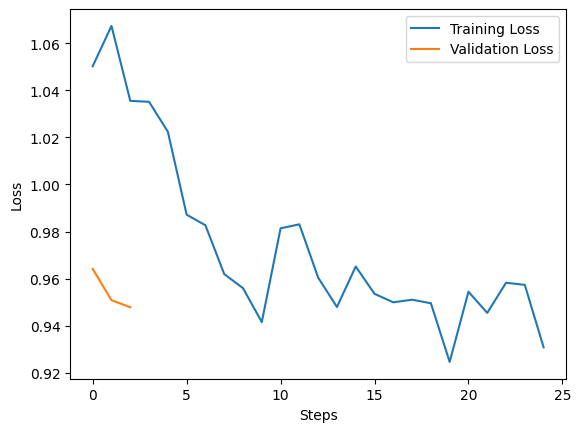

In [ ]:
# Obtener historial del entrenamiento
history = trainer.state.log_history

# Curvas de pérdida
train_loss = [x["loss"] for x in history if "loss" in x]
eval_loss = [x["eval_loss"] for x in history if "eval_loss" in x]
steps = list(range(len(train_loss)))

plt.plot(steps, train_loss, label="Training Loss")
plt.plot(steps[:len(eval_loss)], eval_loss, label="Validation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Preguntas

**Cual es el principo de LoRA?**
* Porque se usan menos parametros?
* Que significa el rango del adaptador?

**Cuales son las diferencias sin y con usar LoRA?** 
* Se puede entrenar sin LoRA? 
* Cae en la memoria?
* Es mas lento/rapido?
* Como cambian las performancias?

**Respuestas**

1) LoRA es una técnica para adaptar modelos, para que a la hora de hacer Finetuning se realice con un número mucho menor de parámetros en comparación con el modelo completo. El principio que esta detrás de estop es utilizar aproximaciones de bajo rango, para ajustar solo una parte del modelo.
* LoRA usa una aproximación de bajo rango para modificar las matrices de pesos del modelo y en vez de ajustar todos los parámetros, LoRA introduce adaptadores de bajo rango que solo modifican un subconjunto de los pesos del modelo. Esto swe logra mediante la factorización de las actualizaciones de peso en productos de matrices de rango reducido/
* El rango en LoRA se refiere al tamaño de las matrices de bajo rango que se utilizan para modificar los pesos del modelo original. Si un adaptador tiene un rango pequeño, significa que solo una pequeña cantidad de parámetros adicionales se están entrenando. La idea detrás de esto es que un rango bajo permite capturar las modificaciones necesarias en las representaciones del modelo con un número significativamente reducido de parámetros, sin perder la capacidad de ajuste.

2) La principal diferencia entre entrenar sin y con LoRA es que con LoRA se reduce significativamente la cantidad de parámetros a entrenar y por ende se acelera el entrenamiento y se logra entrenar con menos recursos
* La respuesta a esta pregunta depende de los recursos con los que se cuente, pero para una persona común no se podria debido a las necesidades de hardware para entrenar un modelo con un número tan elevado de parámetros lo hace imposible
* LoRA generalmente reduce el uso de memoria en comparación con entrenar todos los parámetros del modelo. Esto se debe a que solo se almacenan y se ajustan las matrices de bajo rango, lo que reduce significativamente la cantidad de parámetros entrenables. 
* LoRA puede ser más rápido que entrenar el modelo completo. Esto es porque solo se entrenan los adaptadores de bajo rango, lo que reduce el costo computacional asociado con el entrenamiento de todos los parámetros del modelo. 
* LoRA ofrece una solución intermedia entre la eficiencia computacional y el rendimiento. Aunque no siempre alcanza la misma precisión que el entrenamiento completo del modelo, ofrece un buen equilibrio entre eficiencia y rendimiento, especialmente cuando los recursos computacionales son limitados.

# Load a model using quantization

* Use `BitsAndBytes` in order to load a model that you could not load without quantization
* Print the quantity of memory the model takes in the GPU in each case (8 bits, 4 bits)

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at google/flan-t5-large and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 2,359,296 || all params: 753,662,979 || trainable%: 0.3130


C:\Users\Daniel\AppData\Local\Temp\ipykernel_12600\485435975.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
  4%|▍         | 100/2529 [00:40<16:07,  2.51it/s]

{'loss': 0.8902, 'grad_norm': nan, 'learning_rate': 1.9209173586397787e-05, 'epoch': 0.12}


  8%|▊         | 200/2529 [01:20<15:24,  2.52it/s]

{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 1.8418347172795573e-05, 'epoch': 0.24}


 12%|█▏        | 300/2529 [02:00<14:50,  2.50it/s]

{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 1.762752075919336e-05, 'epoch': 0.36}


 16%|█▌        | 400/2529 [02:40<14:08,  2.51it/s]

{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 1.6836694345591145e-05, 'epoch': 0.47}


 20%|█▉        | 500/2529 [03:21<13:45,  2.46it/s]

{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 1.604586793198893e-05, 'epoch': 0.59}


 24%|██▎       | 600/2529 [04:02<13:28,  2.39it/s]

{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 1.5255041518386714e-05, 'epoch': 0.71}


 28%|██▊       | 700/2529 [04:43<12:02,  2.53it/s]

{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 1.44642151047845e-05, 'epoch': 0.83}


 32%|███▏      | 800/2529 [05:22<11:21,  2.54it/s]

{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 1.3673388691182286e-05, 'epoch': 0.95}


                                                  
 33%|███▎      | 843/2529 [06:27<11:14,  2.50it/s]

{'eval_loss': nan, 'eval_runtime': 47.6744, 'eval_samples_per_second': 48.202, 'eval_steps_per_second': 6.041, 'epoch': 1.0}


 36%|███▌      | 900/2529 [06:50<10:44,  2.53it/s]  

{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 1.2882562277580073e-05, 'epoch': 1.07}


 40%|███▉      | 1000/2529 [07:30<10:04,  2.53it/s]

{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 1.2091735863977859e-05, 'epoch': 1.19}


 43%|████▎     | 1100/2529 [08:10<09:27,  2.52it/s]

{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 1.1300909450375643e-05, 'epoch': 1.3}


 47%|████▋     | 1200/2529 [08:50<08:58,  2.47it/s]

{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 1.0510083036773429e-05, 'epoch': 1.42}


 51%|█████▏    | 1300/2529 [09:31<08:19,  2.46it/s]

{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 9.719256623171214e-06, 'epoch': 1.54}


 55%|█████▌    | 1400/2529 [10:12<07:50,  2.40it/s]

{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 8.928430209569e-06, 'epoch': 1.66}


 59%|█████▉    | 1500/2529 [10:53<06:58,  2.46it/s]

{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 8.137603795966786e-06, 'epoch': 1.78}


 63%|██████▎   | 1600/2529 [11:34<06:25,  2.41it/s]

{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 7.3467773823645715e-06, 'epoch': 1.9}


                                                   
 67%|██████▋   | 1686/2529 [12:56<05:37,  2.50it/s]

{'eval_loss': nan, 'eval_runtime': 47.823, 'eval_samples_per_second': 48.052, 'eval_steps_per_second': 6.022, 'epoch': 2.0}


 67%|██████▋   | 1700/2529 [13:02<07:28,  1.85it/s]  

{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 6.555950968762357e-06, 'epoch': 2.02}


 71%|███████   | 1800/2529 [13:42<04:49,  2.52it/s]

{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 5.765124555160143e-06, 'epoch': 2.14}


 75%|███████▌  | 1900/2529 [14:22<04:10,  2.51it/s]

{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 4.974298141557929e-06, 'epoch': 2.25}


 79%|███████▉  | 2000/2529 [15:02<03:32,  2.49it/s]

{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 4.183471727955714e-06, 'epoch': 2.37}


 83%|████████▎ | 2100/2529 [15:42<02:49,  2.53it/s]

{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 3.3926453143535e-06, 'epoch': 2.49}


 87%|████████▋ | 2200/2529 [16:22<02:10,  2.51it/s]

{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 2.601818900751285e-06, 'epoch': 2.61}


 91%|█████████ | 2300/2529 [17:02<01:33,  2.44it/s]

{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 1.8109924871490709e-06, 'epoch': 2.73}


 95%|█████████▍| 2400/2529 [17:44<00:52,  2.46it/s]

{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 1.0201660735468566e-06, 'epoch': 2.85}


 99%|█████████▉| 2500/2529 [18:26<00:12,  2.37it/s]

{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 2.2933965994464219e-07, 'epoch': 2.97}


                                                   
100%|██████████| 2529/2529 [19:26<00:00,  2.17it/s]


{'eval_loss': nan, 'eval_runtime': 47.7392, 'eval_samples_per_second': 48.137, 'eval_steps_per_second': 6.033, 'epoch': 3.0}
{'train_runtime': 1166.7359, 'train_samples_per_second': 17.333, 'train_steps_per_second': 2.168, 'train_loss': 0.03519814680950969, 'epoch': 3.0}


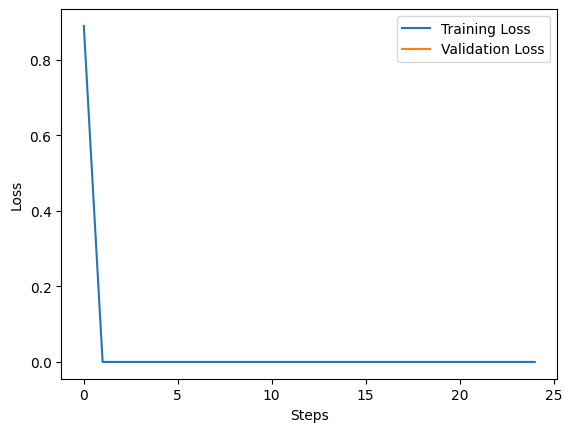

Memoria usada en GPU: 1012.21 MB


In [9]:
# TODO 
# Cargar modelo con cuantización de BitsAndBytes
model_name = "google/flan-t5-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)


quantization_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype="float16", bnb_4bit_use_double_quant=True)


model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,
    device_map="auto",  
    quantization_config=quantization_config,  # Cuantización de 4 bits
)

lora_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM,
    inference_mode=False,
    r=8,  
    lora_alpha=16,
    lora_dropout=0.1,
)

# Convertir el modelo con LoRA
peft_model = get_peft_model(model, lora_config)
peft_model.to(device)

# Verificar parámetros entrenables
peft_model.print_trainable_parameters()

# Argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir="./results",  
    eval_strategy="epoch",  
    learning_rate=2e-5,  
    per_device_train_batch_size=8,  
    per_device_eval_batch_size=8, 
    num_train_epochs=3,  
    weight_decay=0.01,
    logging_dir='./logs',  
    logging_steps=100, 
    save_steps=1000, 
    eval_steps=500,  
)

# Trainer
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=dev_data,
    tokenizer=tokenizer,
)

# Entrenar el modelo
trainer.train()

# Obtener historial del entrenamiento
history = trainer.state.log_history

# Graficar curvas de pérdida
train_loss = [x["loss"] for x in history if "loss" in x]
eval_loss = [x["eval_loss"] for x in history if "eval_loss" in x]
steps = list(range(len(train_loss)))

plt.plot(steps, train_loss, label="Training Loss")
plt.plot(steps[:len(eval_loss)], eval_loss, label="Validation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Comparación de memoria
print(f"Memoria usada en GPU: {torch.cuda.memory_allocated() / 1e6:.2f} MB")

In [ ]:
# No logre ejecutar el modelo con cuantización de 8 bits, me arroja el siguiente error :(
# Link a un hilo con mi mismo problema: 
# https://discuss.huggingface.co/t/normal-kernel-cpu-not-implemented-for-char-when-trying-to-import-8-bit-model/72349/3
# https://github.com/bitsandbytes-foundation/bitsandbytes/issues/1097

# Cargar modelo con cuantización de BitsAndBytes
model_name = "google/flan-t5-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
#8 bits
quantization_config = BitsAndBytesConfig(
    load_in_8bit=True,
)


model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,
    device_map="auto",
    quantization_config=quantization_config,  # Cuantización de 8 bits
    torch_dtype=torch.float32,
)

lora_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM,
    inference_mode=False,
    r=8,  
    lora_alpha=16,
    lora_dropout=0.1,
)

# Convertir el modelo con LoRA
peft_model = get_peft_model(model, lora_config)
peft_model.to(device)

# Verificar parámetros entrenables
peft_model.print_trainable_parameters()

# Argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir="./results",  
    eval_strategy="epoch",  
    learning_rate=2e-5,  
    per_device_train_batch_size=8,  
    per_device_eval_batch_size=8, 
    num_train_epochs=3,  
    weight_decay=0.01,
    logging_dir='./logs',  
    logging_steps=100, 
    save_steps=1000, 
    eval_steps=500,  
)

# Trainer
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=dev_data,
    tokenizer=tokenizer,
)


# Entrenar el modelo
trainer.train()

# Obtener historial del entrenamiento
history = trainer.state.log_history

# Graficar curvas de pérdida
train_loss = [x["loss"] for x in history if "loss" in x]
eval_loss = [x["eval_loss"] for x in history if "eval_loss" in x]
steps = list(range(len(train_loss)))

plt.plot(steps, train_loss, label="Training Loss")
plt.plot(steps[:len(eval_loss)], eval_loss, label="Validation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Comparación de memoria
print(f"Memoria usada en GPU: {torch.cuda.memory_allocated() / 1e6:.2f} MB")


## Preguntas

* Cuánta memoria se puede ahorrar?
* Cuál es el interés de esta técnica?

**Respuestas**

* Teoricamente al pasar de una representación por defecto de 32 bits a una de  8 0 4 bits se puede pasar a un modelo que ocupa 1/4 o 1/8 respectivamente del original sin tener que disminuir la cantidad de parámetros, en la practica con el modelo de 4 bits tuvimos un uso de VRam de 1gb aproximadamente vs que el modelo por defecto (usando LoRA) nos dio un consumo de VRam de aproximadamente 3gb, lo que si bien es significativo no llega a la diferencia esperada

* El interés de esta técnica es que permite usar modelos grandes y finetunearlos con recursos limitados sin tener que disminuir el número de parámetros a entrenar. Pero el costo de usar esta tecnica es perder precisión de los valores de cada parametros ya que se pasa de ser representados por 32 bits a 4 u 8 bits solamente